IDEA:

During the morning rush hour, more people will ride bikes into Midtown than will ride bikes out of Midtown. A similar statement could be said in reverse about the afternoon rush hour.

$H_0:$ On weekdays between the hours of 7:00 AM and 10:00 AM, the number of bike trips originating in Midtown Manhattan, as defined by 59th Street to the north, 9th Avenue to west, 36th Street to the south and 2nd Avenue to the east, and ending outside will be at least as great as the number of bike trips originating outside of Midtown and finishing inside.

$H_1:$ On weekdays  between the hours of 7:00 AM and 10:00 AM, the number of bike trips originating outside of Midtown Manhattan ending inside will be greater than the number of bike trips originating inside and ending outside. This will be significant with $p < 0.01$.

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

puidata = os.getenv("PUIDATA")
sitename = "http://s3.amazonaws.com/tripdata"
bikemon = "201508" # Would like this to be settable during runtime
# Define corners of Midtown
nwcorn = (40.7693944, -73.9870549) # W 59th & 8th
swcorn = (40.7544542, -73.99989933)# W 36th & 8th
secorn = (40.7475701, -73.9742955) # E 36th & 2nd
necorn = (40.7591923, -73.9665707) # E 59th & 2nd
boundary = (nwcorn, swcorn, secorn, necorn)

def getBikeDataCSV(mon):
    # Based loosely on Federica's code
    basename = mon + "-citibike-tripdata"
    zipname = basename + ".zip"
    os.chdir(puidata) # Now all file operations without an absolute path will take place in puidata
    fullfile = puidata + "/" + zipname
    # Check if the file is present
    print("Checking presence of " + zipname)
    print(os.getenv("PWD"))
    if os.path.isfile(basename + ".csv"):
        print("Found file " + basename + ".csv")
        if os.path.isfile(mon + "-citibike-tripdata.csv"):
            if os.system("mv " + mon + "-citibike-tripdata.csv " + puidata):
                print("Could not move file to " + puidata)
                return
    else:
        print("Downloading file " + zipname)
        if not os.path.isfile(fullfile):
            os.system("curl -O " + sitename + "/" + zipname)
            if os.path.isfile(fullfile):
                print("Got " + zipname + "\n")
                os.system("unzip -q " + fullfile)
            else:
                print("Failed\n")
                return

Populating the interactive namespace from numpy and matplotlib


In [2]:
def in_rect(ptlat, ptlon, contour):
    # ptlat - scalar latitude of the coordinate being tested
    # ptlon - scalar longitude of the coordinate being tested
    # contour - tuple of coordinates bounding polygon
    # First look for two pairs of points in contour where
    # which ptlat is between
    bet_segs = []
    eq_pt = []
    try:
        for corner in range(0, len(contour)):
            if between(ptlat, contour[corner][0], contour[(corner + 1) % len(contour)][0]):
                bet_segs.append(corner)
            elif ptlat == contour[corner][0]:
                eq_pt.append(corner)
    except ValueError:
        return False
    # If there were no segments, return False
    if len(bet_segs) <= 1 and len(eq_pt) == 0:
        return False
    # If there is one equal to a vertex and none inside segment,
    # return whether it is on the vertex
    if len(eq_pt) == 1 and len(bet_segs) == 0:
        return ptlon == contour[eq_pt[0]][1]
    # If there are two equal to a vertex and none inside segment,
    # return whether it is on the line connecting those vertices, including ends
    if len(eq_pt) == 2 and len(bet_segs) == 0:
        return between(ptlon, contour[eq_pt[0]][1], contour[eq_pt[1]][1]
                      ) or ptlon == contour[eq_pt[0]][1] or ptlon == contour[eq_pt[1]][1]
    # If there are two or more segments, find the longitude-intercepts
    # for each of those segments with the latitude and return whether or
    # not the point is on a longitude in between
    if len(bet_segs) >= 2:
        xint_list = []
        # Find the longitude on each segment in the list intersecting the latitude
        for ver in bet_segs:
            xint = x_intercept(ptlat, ptlon, (contour[ver], contour[(ver+1) % len(contour)]))
            xint_list.append(xint)
        lessthan_lon = 0
        # If the number of segments with an x-intercept greater than the points x-coordinate
        # is odd, the point is in the polygon
        for xi in xint_list:
            if xi == ptlon:
                # On the segment
                return True
            if xi < ptlon:
                lessthan_lon += 1
        return (lessthan_lon % 2) == 1

def x_intercept(ptlat, ptlon, seg_ends):
    # Return the x-coordinate of the segment defined by seg_ends that has a y-coordinate of ptlat
    if seg_ends[0][0] == seg_ends[1][0]:
        if ptlat == seg_ends[0][0]:
            if between(ptlon, seg_ends[0][1], seg_ends[1][1]):
                return ptlon
            else:
                return Null
        else:
            return Null
    if seg_ends[0][1] == seg_ends[1][1]:
        return seg_ends[0][1]
    y_frac = (ptlat - seg_ends[0][0]) / (seg_ends[1][1] - seg_ends[0][1])
    x_int = seg_ends[0][1] + y_frac * (seg_ends[1][1] - seg_ends[0][1])
    return x_int

def between (compare, st, en):
    if st < compare and compare < en:
        return True
    if en < compare and compare < st:
        return True
    return False


In [3]:
print(os.getenv("PUIDATA"))
#puidata = os.getenv("PUI2016") + "/data" # This should be fixed in subsequent iterations
# Obtain the data from online for the specified months
getBikeDataCSV(bikemon)
raw = pd.read_csv(puidata + "/" + bikemon + "-citibike-tripdata.csv")
# Remove the unneeded fields
raw = raw.drop(["tripduration", "bikeid", "usertype", "birth year", "gender"], axis=1)
# Create the fields that will hold the calculated values whether the start and end are in Midtown
#raw["st_in"] = pd.Series(np.zeros(len(raw["starttime"]), np.int8))
#raw["en_in"] = pd.Series(np.zeros(len(raw["starttime"]), np.int8))
print("Selecting by location")
# Previously, there was a bug in the in_rect() subroutine that prevented getting accurate assessments
# of what was in Midtown. It was fixed offline, but could not test it with pandas due to Xauth problem on gw
# This doesn't work as intended, will use a different method
#raw.loc[in_rect(raw["end station latitude"], raw["end station longitude"],
#                   boundary), "en_in"] = 1
#raw.loc[in_rect(raw["start station latitude"], raw["start station longitude"],
#                   boundary), "st_in"] = 1
#print("Identified points in and out of Midtown")
raw.head(5)

/home/cusp/ss4977/PUIdata
Checking presence of 201508-citibike-tripdata.zip
/wingrdp/homedirs/ss4977/PUI2016_ss4977/HW3_ss4977
Found file 201508-citibike-tripdata.csv
Could not move file to /home/cusp/ss4977/PUIdata
Selecting by location


,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude
0,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033
1,8/1/2015 00:00:05,8/1/2015 00:05:06,450,W 49 St & 8 Ave,40.762272,-73.987882,479,9 Ave & W 45 St,40.760193,-73.991255
2,8/1/2015 00:00:06,8/1/2015 00:07:18,312,Allen St & E Houston St,40.722055,-73.989111,296,Division St & Bowery,40.714131,-73.997047
3,8/1/2015 00:00:09,8/1/2015 00:04:43,382,University Pl & E 14 St,40.734927,-73.992005,229,Great Jones St,40.727434,-73.993790
4,8/1/2015 00:00:17,8/1/2015 00:21:13,352,W 56 St & 6 Ave,40.763406,-73.977225,432,E 7 St & Avenue A,40.726218,-73.983799


In [5]:
# Hmm, the update of st_in seenmed to set everything to the same value as en_in.
# en_in is right, try something else for st_in
# Identify all of the unique stations as either in or out of Midtown, later create a DataFrame
# based on that
station_conds = {}
for row in range(0, len(raw["start station name"])):
    if row % 200000 == 0:
        print(str(row))
    name = raw["start station name"][row]
    if name in station_conds.keys():
        pass
    else:
        lat = raw["start station latitude"][row]
        lon = raw["start station longitude"][row]
        if in_rect(lat, lon, boundary):
            station_conds[name] = 1
        else:
            station_conds[name] = 0
    name = raw["end station name"][row]
    if name in station_conds.keys():
        pass
    else:
        lat = raw["end station latitude"][row]
        lon = raw["end station longitude"][row]
        if in_rect(lat, lon, boundary):
            station_conds[name] = 1
        else:
            station_conds[name] = 0


0
200000
400000
600000
800000
1000000


In [6]:
pdLookIn = pd.DataFrame(station_conds.items(), columns=['start station name', 'st_in'])
pdLookOut = pd.DataFrame(station_conds.items(), columns=['end station name', 'en_in'])
joinIn = pd.merge(raw, pdLookIn, on="start station name")
join = pd.merge(joinIn, pdLookOut, on="end station name")
join.head(5)

,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,st_in,en_in
0,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1
1,8/2/2015 00:39:11,8/2/2015 00:56:41,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1
2,8/9/2015 23:54:38,8/10/2015 00:13:54,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1
3,8/23/2015 00:35:22,8/23/2015 00:52:01,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1
4,8/24/2015 00:02:45,8/24/2015 00:19:57,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1


In [7]:
# Remove all entries where both ends either are both in Midtown or both not in Midtown
print(join.shape)
dFrame = join[join["st_in"] != join["en_in"]]
dFrame.shape

(1179044, 12)


(256551, 12)

In [8]:
# Identify which entries are on days of the week and hours of interest
dFrame["st_date"] = pd.to_datetime(dFrame["starttime"])
print("Added start as datetime")
dFrame["en_date"] = pd.to_datetime(dFrame["stoptime"])
print("Added end as datetime")
#for nkey in "weekday", "day", "sttime", "etime":
#    dFrame[nkey] = pd.Series(np.zeros(len(dFrame["st_date"]), np.int8))
dFrame["weekday"] = dFrame["st_date"].dt.weekday
dFrame["day"] = dFrame["st_date"].dt.day
dFrame["sttime"] = dFrame["st_date"].dt.hour
dFrame["etime"] = dFrame["en_date"].dt.hour
dFrame.head(5)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Added start as datetime


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Added end as datetime


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,st_in,en_in,st_date,en_date,weekday,day,sttime,etime
0,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-01 00:00:04,2015-08-01 00:20:07,5,1,0,0
1,8/2/2015 00:39:11,8/2/2015 00:56:41,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-02 00:39:11,2015-08-02 00:56:41,6,2,0,0
2,8/9/2015 23:54:38,8/10/2015 00:13:54,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-09 23:54:38,2015-08-10 00:13:54,6,9,23,0
3,8/23/2015 00:35:22,8/23/2015 00:52:01,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-23 00:35:22,2015-08-23 00:52:01,6,23,0,0
4,8/24/2015 00:02:45,8/24/2015 00:19:57,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-24 00:02:45,2015-08-24 00:19:57,0,24,0,0


In [9]:
rushhr = dFrame.loc[(dFrame["weekday"] < 5) &
                    (((dFrame["sttime"] >= 7) & (dFrame["sttime"] < 10) |
                     ((dFrame["etime"] >= 7) & (dFrame["etime"] < 10))))]
rushhr.head(5)

,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,st_in,en_in,st_date,en_date,weekday,day,sttime,etime
14,8/28/2015 09:02:36,8/28/2015 09:21:00,312,Allen St & E Houston St,40.722055,-73.989111,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-28 09:02:36,2015-08-28 09:21:00,4,28,9,9
70,8/6/2015 09:37:18,8/6/2015 09:59:40,285,Broadway & E 14 St,40.734546,-73.990741,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-06 09:37:18,2015-08-06 09:59:40,3,6,9,9
106,8/21/2015 08:54:05,8/21/2015 09:18:06,336,Sullivan St & Washington Sq,40.730477,-73.999061,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-21 08:54:05,2015-08-21 09:18:06,4,21,8,9
107,8/24/2015 08:52:06,8/24/2015 09:16:47,336,Sullivan St & Washington Sq,40.730477,-73.999061,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-24 08:52:06,2015-08-24 09:16:47,0,24,8,9
108,8/25/2015 08:48:29,8/25/2015 09:16:43,336,Sullivan St & Washington Sq,40.730477,-73.999061,385,E 55 St & 2 Ave,40.757973,-73.966033,0,1,2015-08-25 08:48:29,2015-08-25 09:16:43,1,25,8,9


In [10]:
# Calculate aggregated statistics. Will test when X is working from gw
enter = rushhr[rushhr["en_in"] == 1]
leave = rushhr[rushhr["st_in"] == 1]
enter_stats = enter.groupby(['day', 'sttime']).agg({'en_in': [np.size]})
leave_stats = leave.groupby(['day', 'sttime']).agg({'st_in': [np.size]})
print(leave.shape)
print(enter.shape)
print(rushhr.shape)

(21745, 18)
(25912, 18)
(47657, 18)


In [14]:
enter_byhr = enter.groupby(['day', 'sttime'])
leave_byhr = leave.groupby(['day', 'sttime'])
enter_byhr.count()

starttime  stoptime  start station id  start station name  \
day sttime                                                              
3   6              38        38                38                  38   
    7             351       351               351                 351   
    8             521       521               521                 521   
    9             341       341               341                 341   
4   6              50        50                50                  50   
    7             310       310               310                 310   
    8             573       573               573                 573   
    9             369       369               369                 369   
5   6              45        45                45                  45   
    7             328       328               328                 328   
    8             592       592               592                 592   
    9             369       369               369                 369   
    19              1         1                 1                   1   
6   6              39        39                39                  39   
    7             353       353               353                 353   
    8             636       636               636                 636   
    9             388       388               388                 388   
    23              1         1                 1                   1   
7   6              55        55                55                  55   
    7             276       276               276                 276   
    8             563       563               563                 563   
    9             347       347               347                 347   
10  6              50        50                50                  50   
    7             320       320               320                 320   
    8             580       580               580                 580   
    9             349       349               349                 349   
    20              1         1                 1                   1   
11  0               1         1                 1                   1   
    6               4         4                 4                   4   
    7              39        39                39                  39   
...               ...       ...               ...                 ...   
21  23              1         1                 1                   1   
24  0               1         1                 1                   1   
    6              46        46                46                  46   
    7             321       321               321                 321   
    8             490       490               490                 490   
    9             323       323               323                 323   
    16              1         1                 1                   1   
    19              1         1                 1                   1   
25  6              59        59                59                  59   
    7             334       334               334                 334   
    8             543       543               543                 543   
    9             358       358               358                 358   
26  5               1         1                 1                   1   
    6              58        58                58                  58   
    7             336       336               336                 336   
    8             605       605               605                 605   
    9             362       362               362                 362   
27  6              61        61                61                  61   
    7             375       375               375                 375   
    8             600       600               600                 600   
    9             395       395               395                 395   
28  6              52        52                52                  52 

We now have that for the month of August 2015, 25912 Citibike trips were taken into Midtown during weekday rush hours, and 21745 trips out. Now to plot this and show a confidence interval. Based on a poisson distribution, the standard deviation is the square root of the count.

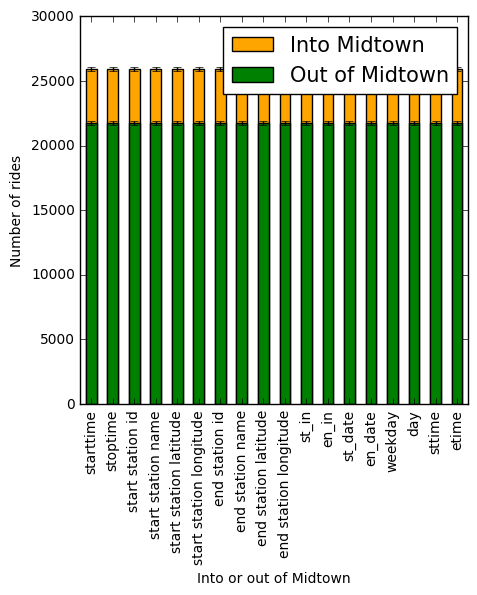

In [20]:
count_in = enter.count()
std_in = np.sqrt(count_in)
count_out = leave.count()
std_out = np.sqrt(count_out)
fig = pl.figure(figsize(5, 5))
ax = count_in.plot(kind="bar", color="orange", yerr=std_in, label="Into Midtown")
count_out.plot(kind="bar", color="green", yerr=std_out, label="Out of Midtown")
ax.set_ylabel("Number of rides")
ax.set_xlabel("Into or out of Midtown")
pl.legend(["Into Midtown", "Out of Midtown"], fontsize=15)